# LEGO Brick Classification with TensorFlow Lite Model Maker

This notebook follows and adapts the Image classification with the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/models/modify/model_maker/image_classification) Google Collab tutorial, a step-by-step lesson on how to make a custom classifier model for mobile use. The [TFLite Model Maker](https://www.tensorflow.org/lite/models/modify/model_maker) library uses transfer learning to reduce the amount of training data requirements and time. The notebook creates a custom LEGO brick classification model using rendered pictures from the chosen dataset.

### **Steps:**


1. **Install and Import Packages**
2. **Load Input Data**
3. **Customize TensorFlow Model**
4. **Export TFLite Model**



## Step 1: Install and Import Packages

In [ ]:
!pip install -q tflite-model-maker 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.8/203.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

## Step 2: Load Input Data

The dataset must have a structured directory, such as the example below:

<pre>
<b>legos</b>
|__ <b>2357 brick corner</b>
    |______ 12357 brick corner 1x2x2 000L.png
    |______ 2357 brick corner 1x2x2 000R
    |______ ...
|__ <b>2420 plate corner</b>
    |______ 2420 plate corner 2x2 000L.png
    |______ 2420 plate corner 2x2 000R.png
    |______ ...
|__ <b>2780 Peg with friction</b>
    |______ 2780 Peg with friction 000L.png
    |______ 2780 Peg with friction 000R.png
    |______ ...
|__ <b>3001 brick</b>
    |______ 3001 brick 2x4 000L.png
    |______ 3001 brick 2x4 000R.png
    |______ ...
|__ <b>3002 brick</b>
    |______ 3002 brick 2x3 000L.png
    |______ 3002 brick 2x3 000R.png
    |______ ...
</pre>

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Check the working directory and change it accordingly

In [ ]:
!pwd

/content


In [ ]:
%cd drive/MyDrive/LEGO/

/content/drive/MyDrive/LEGO


Unzip files

In [ ]:
#!unzip legos447Z.zip

LEGO dataset path

In [ ]:
image_path = 'legos447'

**from_folder() method** -> 
assumes image data of the same class are in the same subdirectory and the subfolder name is the class name

Currently, JPEG-encoded images and PNG-encoded images are supported

In [ ]:
data = DataLoader.from_folder(image_path)

In [ ]:
train_data, rest_data = data.split(0.8) # training data (80%)
validation_data, test_data = rest_data.split(0.5) # validation data (10%, optional) and testing data (10%).

Show 25 image examples with labels

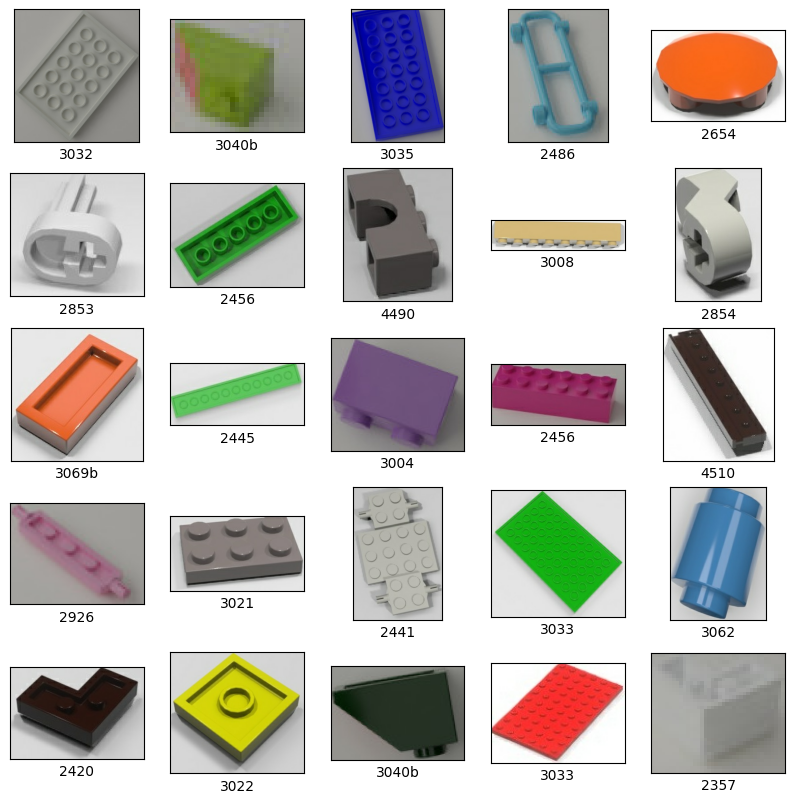

In [ ]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

## Step 3: Customize the TensorFlow Model


Default model is EfficientNet-Lite0

Change Model following this format:

model = image_classifier.create(train_data, model_spec=model_spec.get('mobilenet_v2'), validation_data=validation_data)

The training hyperparameters can be [changed](https://www.tensorflow.org/lite/models/modify/model_maker/image_classification#change_the_training_hyperparameters) like epochs, dropout_rate, and batch_size which could affect the model accuracy:

model = image_classifier.create(train_data, validation_data=validation_data, epochs=10)


In [ ]:
# model = image_classifier.create(train_data, validation_data=validation_data)
model = image_classifier.create(train_data, validation_data=validation_data, epochs=50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 62)                79422     
                                                                 
Total params: 3,492,446
Trainable params: 79,422
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/50
2555/2555 [==============================] - 3357s 1s/step - loss: 1.8619 - accuracy: 0.6522 - val_loss: 1.5095 - val_accuracy: 0.7758
Epoch 2/50
2555/2555 [==============================] - 98s 39ms/step - loss: 1.5299 - a

Detailed model structure

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 62)                79422     
                                                                 
Total params: 3,492,446
Trainable params: 79,422
Non-trainable params: 3,413,024
_________________________________________________________________


Evaluate model results

In [ ]:
loss, accuracy = model.evaluate(test_data)

320/320 [==============================] - 412s 1s/step - loss: 1.2667 - accuracy: 0.8728


Plot 100 test images

red = wrong predicted results

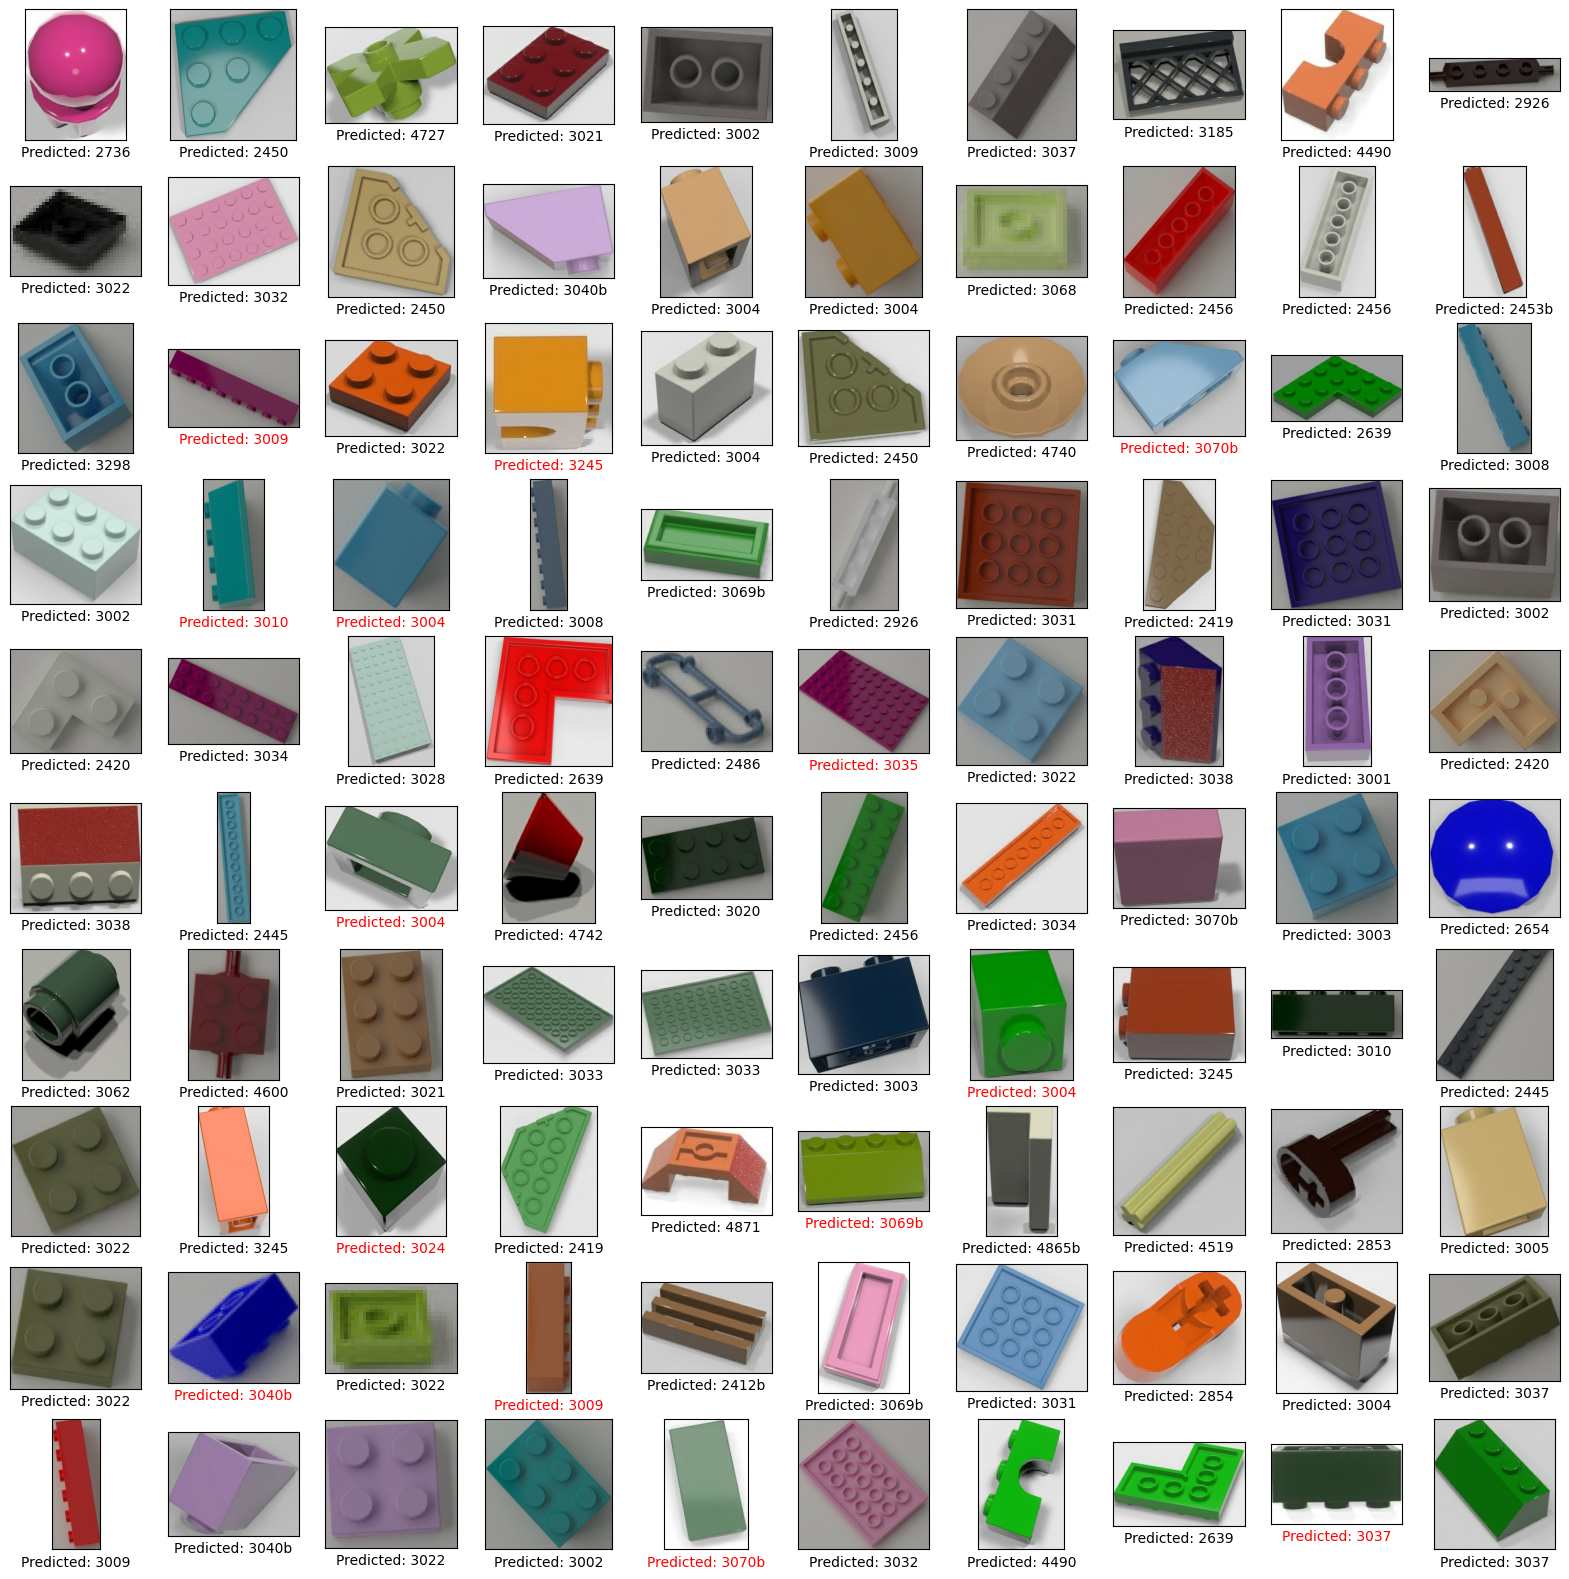

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
#
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

## Step 5: Export to TensorFlow Lite Model

In [ ]:
model.export(export_dir='.')

/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
model.export(export_dir='.', export_format=ExportFormat.LABEL)

In [ ]:
# model.evaluate_tflite('model.tflite', test_data)

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
@misc{tensorflow2015-whitepaper,
title={ {TensorFlow}: Large-Scale Machine Learning on Heterogeneous Systems},
url={https://www.tensorflow.org/},
note={Software available from tensorflow.org},
author={
    Mart\'{i}n~Abadi and
    Ashish~Agarwal and
    Paul~Barham and
    Eugene~Brevdo and
    Zhifeng~Chen and
    Craig~Citro and
    Greg~S.~Corrado and
    Andy~Davis and
    Jeffrey~Dean and
    Matthieu~Devin and
    Sanjay~Ghemawat and
    Ian~Goodfellow and
    Andrew~Harp and
    Geoffrey~Irving and
    Michael~Isard and
    Yangqing Jia and
    Rafal~Jozefowicz and
    Lukasz~Kaiser and
    Manjunath~Kudlur and
    Josh~Levenberg and
    Dandelion~Man\'{e} and
    Rajat~Monga and
    Sherry~Moore and
    Derek~Murray and
    Chris~Olah and
    Mike~Schuster and
    Jonathon~Shlens and
    Benoit~Steiner and
    Ilya~Sutskever and
    Kunal~Talwar and
    Paul~Tucker and
    Vincent~Vanhoucke and
    Vijay~Vasudevan and
    Fernanda~Vi\'{e}gas and
    Oriol~Vinyals and
    Pete~Warden and
    Martin~Wattenberg and
    Martin~Wicke and
    Yuan~Yu and
    Xiaoqiang~Zheng},
  year={2015},
}